In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda")

In [4]:
class Game(object):
    def __init__(self):
        self.states = []
        self.policies = []
        self.value = 0
        
    def add_state(self, state):
        self.states.append(torch.as_tensor(state, dtype=torch.float).reshape(9))
        
    def add_policy(self, policy):
        self.policies.append(torch.as_tensor(policy, dtype=torch.float).reshape(9))
        
    def unpack(self):
        bs = len(self.states)
        state_batch = torch.cat(self.states).reshape(bs, 9)
        policy_batch = torch.cat(self.policies).reshape(bs, 9)
        value_batch = torch.tensor([self.value]*bs, dtype=torch.float).reshape(bs, 1)
        return state_batch, policy_batch, value_batch
    

In [5]:
class Memory(object):
    def __init__(self, max_size=300):
        self.max_size = max_size
        self.games = []
    
    def add_game(self, game):
        if len(self.games) == self.max_size:
            self.games.pop(random.randint(0, self.max_size-1))
        self.games.append(game)
        
    def get_batch(self, n_games=5):
        if len(self.games) <= n_games:
            random.shuffle(self.games)
            return self.games
        return random.sample(self.games, n_games)

In [6]:
class TicTacToe(object):
    def __init__(self):
        self.board = np.zeros((3,3), dtype=np.int32)
    
    def get_valid_actions(self):
        possible_actions = np.where(self.board.reshape(9) == 0)[0]
        
        if len(possible_actions) == 0:
            return None
        
        return possible_actions
    
    def is_finish(self):
        ret = self.get_reward() != 0 or  not(self.board ==0).any()

        return ret
    
    def get_reward(self):
        # check diagonal
        if (self.board.diagonal() == self.board[0][0]).all():
            return self.board[0][0]
        if (self.board[:, ::-1].diagonal() == self.board[0][2]).all():
            return self.board[0][2]
        # check horizontal
        if (self.board[0] == self.board[0][0] ).all():
            return self.board[0][0]
        if (self.board[1] == self.board[1][0]).all():
            return self.board[1][0]
        if (self.board[2] == self.board[2][0]).all():
            return self.board[2][0]
        # check vertical
        if (self.board.T[0] == self.board.T[0][0] ).all():
            return self.board.T[0][0]
        if (self.board.T[1] == self.board.T[1][0]).all():
            return self.board.T[1][0]
        if (self.board.T[2] == self.board.T[2][0]).all():
            return self.board.T[2][0]
        return 0
        
    def perform_action(self, action, player):
        if self.board.reshape(9)[action] != 0:
            raise Exception("invalid action given")
            
        self.board.reshape(9)[action] = player
    
    def get_state(self):
        return self.board.copy()

In [ ]:
class Node(object):
    def __init__(self, prior_prob, player=1, game_action=None, state=None):
        self.state = state
        self.prior_prob = prior_prob     
        self.player = player
        self.game_action = game_action
        self.visit_count = 0
        self.value = 0
        self.children = []
    
    def ucb(self, parent):
        ucb = self.prior_prob * np.sqrt(parent.visit_count)/(1+self.visit_count)
        if self.visit_count > 0:
            ucb -= self.value
        
        return ucb
    
    def is_final(self):
        return self.children == []
    
    def select_child(self):
        return sorted(self.children, key=lambda x: x.ucb(self))[-1]
        
    def initalize_tree(self):
        action_space = np.where(self.state.reshape(9) == 0)[0]
        
        for i in action_space: self.children.append(Node(1/len(action_space), game_action=i, player=-1))
            
        

In [90]:
class MCTS(object):
    def __init__(self, model, num_simulations):
        self.device = next(model.parameters()).device
        #self.model = model
        self.n_simul = num_simulations
        self.root = Node(1, state=np.zeros((3,3)))
        self.root.initalize_tree()
    
    def backprop(self, path, value):
        for node in reversed(path):
            node.value += value * node.player
            node.value /= node.visit_count
    
    def best_action(self, tree):
        return sorted(tree.children, key=lambda x: x.visit_count)[-1].game_action
    
    def get_child_by_action(self, action):
        for c in self.root.children:
            if c.game_action == action:
                return c
    
    def run(self, state, model):
        #print(model(torch.tensor([[0.]*9]).to(self.device)))
        #root = Node(1, state=state)
        #self.root.initalize_tree()
        tree_path = []

        for n in range(self.n_simul):
            current_node = self.root
            game = TicTacToe()
            game.board = state.copy()

            # walk down the tree
            while not current_node.is_final():
                current_node = current_node.select_child()
                
                game.perform_action(current_node.game_action, current_node.player)
                current_state = game.get_state()
                
                current_node.visit_count += 1
                tree_path.append(current_node)
            
            value = game.get_reward()

            if not game.is_finish():
                # expand
                current_node.state = current_state
                tensor_state = torch.as_tensor(current_node.state.reshape(1,9), dtype=torch.float)#.type(torch.LongTensor)
                
                    
                p, v = model(tensor_state.to(self.device))
                #print(p)
                p, v = p.cpu(), v.cpu()

    
                p = p.reshape(9)
                valid_actions = game.get_valid_actions()
                for a in valid_actions:
                    current_node.children.append(Node(game_action=a, prior_prob=p[a], player=current_node.player*-1))
            self.backprop(tree_path[:-1], value)
        
        return self.root.children, self.best_action(self.root)

In [134]:
class Trainer(object):
    def __init__(self, model):
        self.device = next(model.parameters()).device
        self.model = model
        self.game = TicTacToe()
        self.memory = Memory(max_size=500)
        self.mcts = MCTS(self.model, 60)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.000006)
    
    def play(self, n_simulations, show_debug):
        #mcts = MCTS(self.model, 40)
        player = 1
        start_node = None
        #state_history = []
        #policy_history = []
        memory = Game()
        state = np.zeros((3,3))
        
        for i in range(9):                
            if show_debug:
                print(state)
                
            #state_history.append(torch.as_tensor(state, dtype=torch.float).reshape(1,9))
            memory.add_state(state)
            
            children, action = self.mcts.run(state * player, self.model)
            policy = [0,0,0,0,0,0,0,0,0]
            
            for child in children:
                policy[child.game_action] = child.visit_count/n_simulations
                
            #policy_history.append(torch.tensor(policy))
            memory.add_policy(policy)
            self.game.perform_action(action, player)
            reward = self.game.get_reward()
      
            if self.game.is_finish():
                self.game.board = np.zeros((3,3), dtype=np.int32)
                memory.value = reward
                self.mcts.root = start_node
                return memory
            player *= -1
            
            state = self.game.get_state()
            if i == 0:
                start_node = self.mcts.root
                #print(self.mcts.root.children[0].visit_count)
            self.mcts.root = self.mcts.get_child_by_action(action)
                    
    def loss(self, pred_p, pred_v, p, v):
        p_loss = (p * torch.log(pred_p)).sum(dim=1).mean()
        v_loss = torch.sum((v - pred_v)**2)/v.size()[0]
        return v_loss - p_loss

    def train(self, num_iterations, show_debug):
        self.model.train()
        losses = []
        
        #print(self.model(torch.tensor([ [0.]*9 ]).to(device)))
        for i in tqdm(range(num_iterations)):
            self.optimizer.zero_grad()
            play_memory = self.play(25, show_debug)
            
            self.memory.add_game(play_memory)
            batch = self.memory.get_batch(n_games=25)

            for g in batch:
                state_batch, policy_batch, value_batch = g.unpack()
                pred_p, pred_v  = self.model(state_batch.to(device))
                #print(p * torch.log(pred_p))
                model_loss = self.loss(pred_p, pred_v, policy_batch.to(device), value_batch.to(device))
                model_loss.backward()
                
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.1)
                
                self.optimizer.step()

            losses.append(float(model_loss.cpu().detach())/(i+1))
        return losses


In [75]:
class AlphaZero(torch.nn.Module):
    def __init__(self):
        super(AlphaZero, self).__init__()
        
        self.layer1 = torch.nn.Linear(9, 16)
        self.layer2 = torch.nn.Linear(16, 20)
        self.layer3 = torch.nn.Linear(20, 40)
        self.layer4 = torch.nn.Linear(40, 40)
        self.layer5 = torch.nn.Linear(40, 20)
        self.layer6 = torch.nn.Linear(20, 15)
        
        self.action_layer = torch.nn.Linear(15, 9)
        self.value_layer = torch.nn.Linear(15, 1)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        x = F.relu(self.layer6(x))

        
        p = self.action_layer(x)
        v = self.value_layer(x)
        return F.softmax(p, dim=1), torch.tanh(v)

In [105]:
model = AlphaZero().to(device)
trainer = Trainer(model)


In [135]:
trainer = Trainer(model)

In [144]:
loss = trainer.train(num_iterations=100, show_debug=False)

100%|███████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


In [97]:
loss = trainer.train(num_iterations=4, show_debug=False)

100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.58it/s]


In [146]:
trainer.train(num_iterations=4, show_debug=True)

  0%|                                                                               | 0/4 [00:00<?, ?it/s]

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0 0 0]
 [0 1 0]
 [0 0 0]]
[[ 0  0  0]
 [ 0  1  0]
 [ 0 -1  0]]
[[ 0  0  0]
 [ 0  1  0]
 [ 0 -1  1]]
[[ 0  0  0]
 [-1  1  0]
 [ 0 -1  1]]


 25%|█████████████████▊                                                     | 1/4 [00:00<00:01,  1.57it/s]

[[ 0  0  0]
 [-1  1  0]
 [ 1 -1  1]]
[[ 0  0  0]
 [-1  1 -1]
 [ 1 -1  1]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0 0 0]
 [0 1 0]
 [0 0 0]]
[[ 0  0  0]
 [ 0  1  0]
 [ 0 -1  0]]
[[ 0  0  0]
 [ 0  1  0]
 [ 0 -1  1]]
[[ 0  0  0]
 [-1  1  0]
 [ 0 -1  1]]
[[ 0  0  0]
 [-1  1  0]
 [ 1 -1  1]]
[[ 0  0  0]
 [-1  1 -1]
 [ 1 -1  1]]


 50%|███████████████████████████████████▌                                   | 2/4 [00:01<00:01,  1.58it/s]

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0 0 0]
 [0 1 0]
 [0 0 0]]
[[ 0  0  0]
 [ 0  1  0]
 [ 0 -1  0]]
[[ 0  0  0]
 [ 0  1  0]
 [ 0 -1  1]]
[[ 0  0  0]
 [-1  1  0]
 [ 0 -1  1]]


 75%|█████████████████████████████████████████████████████▎                 | 3/4 [00:01<00:00,  1.58it/s]

[[ 0  0  0]
 [-1  1  0]
 [ 1 -1  1]]
[[ 0  0  0]
 [-1  1 -1]
 [ 1 -1  1]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0 0 0]
 [0 1 0]
 [0 0 0]]
[[ 0  0  0]
 [ 0  1  0]
 [ 0 -1  0]]
[[ 0  0  0]
 [ 0  1  0]
 [ 0 -1  1]]
[[ 0  0  0]
 [-1  1  0]
 [ 0 -1  1]]
[[ 0  0  0]
 [-1  1  0]
 [ 1 -1  1]]
[[ 0  0  0]
 [-1  1 -1]
 [ 1 -1  1]]


100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.57it/s]


[462.90582275390625, 9.09070873260498, 592.5189208984375, 99.96099090576172]

In [137]:
model(torch.tensor([[0.]*9]).to(device))

(tensor([[0.1012, 0.1268, 0.1001, 0.0975, 0.0973, 0.1230, 0.1073, 0.1529, 0.0939]],
        device='cuda:0', grad_fn=<SoftmaxBackward>),
 tensor([[0.1344]], device='cuda:0', grad_fn=<TanhBackward>))

In [141]:
model(torch.tensor([[0.]*9]).to(device))

(tensor([[0.1063, 0.1254, 0.1088, 0.0977, 0.0961, 0.1312, 0.1122, 0.1309, 0.0914]],
        device='cuda:0', grad_fn=<SoftmaxBackward>),
 tensor([[0.2371]], device='cuda:0', grad_fn=<TanhBackward>))

In [115]:
%matplotlib inline

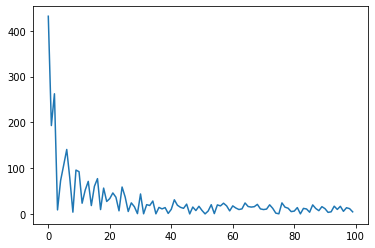

In [145]:
plt.plot(loss)

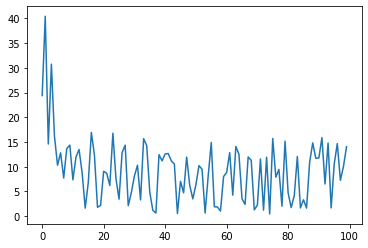

In [35]:
plt.plot(loss)